# Item-Based Collaborative Filtering Recommendation Algorithm

Item-based collaborative filtering makes recommendations based on user-product interactions in the past. The assumption behind the algorithm is that users like similar products and dislike similar products, so they give similar ratings to similar products.

Item-based collaborative filtering algorithm usually has the following steps:

1. Calculate item similarity scores based on all the user ratings.
2. Identify the top n items that are most similar to the item of interest.
3. Calculate the weighted average score for the most similar items by the user.
4. Rank items based on the score and pick top n items to recommend.

## Step 1: Import Python Libraries

In the first step, we will import Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.

We also imported `seaborn` for visualization and `cosine_similarity` for calculating similarity scores.

In [1]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

## Step 2: Data collection

There are multiple datasets in the 100k movielens folder. we will use two ratings and movies.

Now let's read in the rating data.

In [2]:
# Read in data
ratings=pd.read_csv('ratings_small.csv')

# Take a look at the data
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


There are four columns in the ratings dataset, userID, movieID, rating, and timestamp.

The dataset has over 100k records, and there is no missing data.

In [3]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Data summary

In [4]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 671 unique users
The ratings dataset has 9066 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Next, let's read in the movies data to get the movie names.

The movies dataset has movieID, title, and genres.

In [5]:
# Read in data
movies = pd.read_csv('movie.csv')

# Take a look at the data
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Using `movieID` as the matching key, we appended movie information to the rating dataset and named it `df`. So now we have the movie tile and movie rating in the same dataset!


In [6]:
# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Take a look at the data
df

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,7,31,3.0,851868750,Dangerous Minds (1995),Drama
2,31,31,4.0,1273541953,Dangerous Minds (1995),Drama
3,32,31,4.0,834828440,Dangerous Minds (1995),Drama
4,36,31,3.0,847057202,Dangerous Minds (1995),Drama
...,...,...,...,...,...,...
99338,664,64997,2.5,1343761859,War of the Worlds (2005),Action|Sci-Fi
99339,664,72380,3.5,1344435977,"Box, The (2009)",Drama|Horror|Mystery|Sci-Fi|Thriller
99340,665,129,3.0,995232528,Pie in the Sky (1996),Comedy|Romance
99341,665,4736,1.0,1010197684,Summer Catch (2001),Comedy|Romance


## Step 3: Exploratory Data Analysis (EDA)

In step 3, we are filtering the movies and keep only those with over 4 ratings for the analysis.

In [170]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT50 = agg_ratings[agg_ratings['number_of_ratings']>50]

# Check the information of the dataframe
agg_ratings_GT50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 15 to 8737
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              444 non-null    object 
 1   mean_rating        444 non-null    float64
 2   number_of_ratings  444 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 13.9+ KB


Let's check what the most popular movies and their ratings are.

In [171]:
# Check popular movies
agg_ratings_GT50.sort_values(by='number_of_ratings', ascending=False)

,title,mean_rating,number_of_ratings
2874,Forrest Gump (1994),4.054252,341
6262,Pulp Fiction (1994),4.256173,324
6941,"Shawshank Redemption, The (1994)",4.487138,311
7020,"Silence of the Lambs, The (1991)",4.138158,304
7336,Star Wars: Episode IV - A New Hope (1977),4.221649,291
...,...,...,...
1138,Bowfinger (1999),3.068627,51
5115,Mighty Aphrodite (1995),3.637255,51
4139,"Jerk, The (1979)",3.696078,51
950,"Birds, The (1963)",3.754902,51


Next, let's use a `jointplot` to check the correlation between the average rating and the number of ratings.

We can see an upward trend from the scatter plot, showing that popular movies get higher ratings.

The average rating distribution shows that most movies in the dataset have an average rating of around 4.

The number of rating distribution shows that most movies have less than 150 ratings.

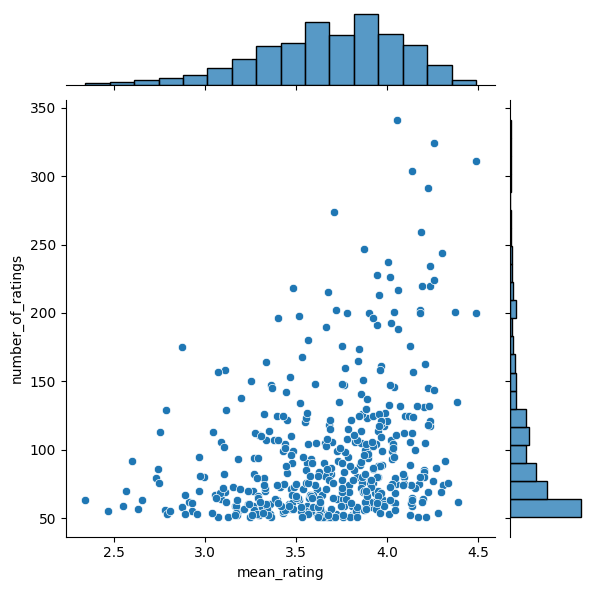

In [172]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT50)

In [173]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT50[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42633 entries, 0 to 42632
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     42633 non-null  int64  
 1   movieId    42633 non-null  int64  
 2   rating     42633 non-null  float64
 3   timestamp  42633 non-null  int64  
 4   title      42633 non-null  object 
 5   genres     42633 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.3+ MB


After filtering the movies with over 100 ratings, we have 597 users that rated 134 movies.

In [174]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 670 unique users
The ratings dataset has 444 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


## Step 4: Create User-Movie Matrix

In step 4, we will transform the dataset into a matrix format. The rows of the matrix are movies, and the columns of the matrix are users. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'.

In [175]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28 Days Later (2002),NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300 (2007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 5: Data Normalization

In Step 5, we will normalize the data by subtracting the average rating of each movie. The cosine similarity calculated based on the normalized data is called mean-centered cosine similarity.

After normalization, the ratings less than the movie's average rating get a negative value, and the ratings more than the movie's average rating get a positive value.

In [176]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.473684,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,0.113821,NaN,NaN,NaN,...,NaN,NaN,0.113821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28 Days Later (2002),NaN,NaN,NaN,NaN,0.192308,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300 (2007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.440678,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 6: Calculate Similarity Score

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this tutorial, we will calculate the item similarity matrix using Pearson correlation.

In [177]:
# Item similarity matrix using Pearson correlation
item_similarity = matrix_norm.T.corr()
item_similarity.head()

title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),About a Boy (2002),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),...,While You Were Sleeping (1995),Who Framed Roger Rabbit? (1988),William Shakespeare's Romeo + Juliet (1996),Willy Wonka & the Chocolate Factory (1971),Witness (1985),"Wizard of Oz, The (1939)",X-Men (2000),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974)
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),1.000000,-0.210149,0.222436,-0.068151,-0.104619,-0.385591,-0.365527,-0.013833,0.596680,0.308892,...,0.193538,0.245277,0.197017,0.015799,0.049183,-0.179197,0.177226,-0.035737,0.335596,-0.045172
12 Angry Men (1957),-0.210149,1.000000,0.104729,0.361158,0.224537,0.263072,0.446791,-0.083251,0.323204,0.175803,...,0.225308,0.453054,0.059308,0.268298,0.407469,0.469118,0.055014,0.388298,0.255769,0.523983
2001: A Space Odyssey (1968),0.222436,0.104729,1.000000,-0.071055,0.034528,-0.009938,0.158227,-0.206524,0.230550,-0.232466,...,-0.517721,-0.136386,0.000000,0.119701,0.080504,0.183597,0.221392,-0.325544,-0.269838,0.285687
28 Days Later (2002),-0.068151,0.361158,-0.071055,1.000000,0.053525,-0.077845,0.308257,0.187546,0.030602,0.109572,...,0.442711,0.134044,0.240772,0.211554,-0.049029,0.229792,0.276815,0.115522,0.462065,0.952579
300 (2007),-0.104619,0.224537,0.034528,0.053525,1.000000,0.129896,0.208937,-0.468637,0.430155,0.308295,...,-0.067648,0.355501,0.482177,0.206330,-0.577350,-0.064455,0.650941,0.328437,0.123909,0.315576


Those who are interested in using cosine similarity can refer to this code. Since `cosine_similarity` does not take missing values, we need to impute the missing values with 0s before the calculation.

In [178]:
# Item similarity matrix using cosine similarity
item_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
item_similarity_cosine

array([[ 1.        , -0.01761255,  0.05516732, ..., -0.0169911 ,
         0.10671479, -0.01158062],
       [-0.01761255,  1.        ,  0.04857941, ...,  0.09725913,
         0.10456069,  0.08072039],
       [ 0.05516732,  0.04857941,  1.        , ..., -0.1039785 ,
        -0.05367487,  0.09042761],
       ...,
       [-0.0169911 ,  0.09725913, -0.1039785 , ...,  1.        ,
         0.03838416,  0.02936839],
       [ 0.10671479,  0.10456069, -0.05367487, ...,  0.03838416,
         1.        , -0.01898024],
       [-0.01158062,  0.08072039,  0.09042761, ...,  0.02936839,
        -0.01898024,  1.        ]])

In the movie similarity matrix, the values range from -1 to 1, where -1 means opposite movie similarity and 1 means very high movie similarity.

## Step 7: Predict User's Rating For One Movie

In step 7, we will predict a user's rating for one movie. Let's use user 1 and the movie American Pie as an example.

The prediction follows the process below:
1. Create a list of the movies that user 2 has watched and rated.
2. Rank the similarities between the movies user 2 rated and American Pie.
3. Select top n movies with highest similarity scores.
4. Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1.

Now let's implement the process using Python.

Firstly, we removed all the movies that have a missing rating for user 2, and sorted the movies by the ratings.

In [185]:
# Pick a user ID
picked_userid = 2

# Pick a movie
picked_movie = 'American Pie (1999)'

# Movies that the target user has watched
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={picked_userid:'rating'})

picked_userid_watched.head(10)

,title,rating
0,Batman (1989),1.602041
1,Clueless (1995),1.450000
2,Dances with Wolves (1990),1.282178
3,Batman Forever (1995),1.217054
4,Apollo 13 (1995),1.097500
5,Terminator 2: Judgment Day (1991),0.993671
6,Interview with the Vampire: The Vampire Chroni...,0.604000
7,GoldenEye (1995),0.549180
8,Mrs. Doubtfire (1993),0.532680
9,"Firm, The (1993)",0.527273


Next, we get the similarity score of the movie American Pie with the movie user 1 has watched, and pick the top 5 movies with the highest similarity score.

In [180]:
# Similarity score of the movie American Pie with all the other movies
picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})

# Rank the similarities between the movies user 1 rated and American Pie.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                            right=picked_movie_similarity_score,
                                            on='title',
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]

# Take a look at the User 1 watched movies with highest similarity
picked_userid_watched_similarity

,title,rating,similarity_score
29,Disclosure (1994),-0.173077,0.728522
21,Clear and Present Danger (1994),0.213043,0.573775
20,Waterworld (1995),0.247788,0.513033
5,Batman Forever (1995),1.217054,0.506464
10,"Client, The (1994)",0.671429,0.504512


After that, calculate the weighted average of ratings and similarities scores, so the movies with higher similarity scores get more weight. This weighted average is the predicted rating for American Pie by user 1.

In [181]:
# Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)

print(f'The predicted rating for {picked_movie} by user {picked_userid} is {predicted_rating}' )

The predicted rating for American Pie (1999) by user 2 is 0.381561


## Step 8: Movie Recommendation

An item-item movie recommendation system following four steps:
1. Create a list of movie that the target user has not watched before.
2. Loop through the unwatched movie and create predicted scores for each movie.
3. Rank the predicted score of unwatched movie from high to low.
4. Select the top k movies as the recommendations for the target user.

The Python function below implemented the four steps. With the input of `picked_userid`, `number_of_similar_items`, and `number_of_recommendations`, we can get the top movies for the user and their corresponding ratings. Note that the ratings are normalized by extracting the average rating for the movie, so we need to add the average value back to the predicted ratings if we want the predicted ratings to be on the same scale as the original ratings.

In [182]:
# Item-based recommendation function
def item_based_rec(picked_userid, number_of_similar_items, number_of_recommendations):
  import operator
  # Movies that the target user has not watched
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[picked_userid]==True]['title'].values.tolist()

  # Movies that the target user has watched
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={picked_userid:'rating'})

  # Dictionary to save the unwatched movie and predicted rating pair
  rating_prediction ={}

  # Loop through unwatched movies
  for picked_movie in picked_userid_unwatched:
    # Calculate the similarity score of the picked movie iwth other movies
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Rank the similarities between the picked user watched movie and the picked unwatched movie.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                                right=picked_movie_similarity_score,
                                                on='title',
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                        weights=picked_userid_watched_similarity['similarity_score']), 3)
    # Save the predicted rating in the dictionary
    rating_prediction[picked_movie] = predicted_rating
    # Return the top recommended movies
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

# Get recommendations
recommended_movie = item_based_rec(picked_userid=100, number_of_similar_items=5, number_of_recommendations =10)
recommended_movie

[('Eternal Sunshine of the Spotless Mind (2004)', 0.676),
 ('Star Trek (2009)', 0.56),
 ('40-Year-Old Virgin, The (2005)', 0.524),
 ('Eyes Wide Shut (1999)', 0.512),
 ('Prestige, The (2006)', 0.469),
 ('Fight Club (1999)', 0.449),
 ('Groundhog Day (1993)', 0.393),
 ('Trainspotting (1996)', 0.383),
 ('Seven (a.k.a. Se7en) (1995)', 0.363),
 ('Animal House (1978)', 0.357)]